In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import ensemble

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
train = pd.read_csv("./data/train.csv")
target = train['target'].values
train = train.drop(['ID','target','v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)
test = pd.read_csv("./data/test.csv")
id_test = test['ID'].values
test = test.drop(['ID','v8','v23','v25','v31','v36','v37','v46','v51','v53','v54','v63','v73','v75','v79','v81','v82','v89','v92','v95','v105','v107','v108','v109','v110','v116','v117','v118','v119','v123','v124','v128'],axis=1)

In [3]:
from sklearn.cross_validation import StratifiedKFold

In [16]:
skf = StratifiedKFold(target, n_folds=5)

In [24]:
preds = np.zeros(target.shape)
for train_index, test_index in skf:
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    for (train_name, train_series), (test_name, test_series) in zip(X_train.iteritems(),X_test.iteritems()):
        if train_series.dtype == 'O':
            #for objects: factorize
            X_train[train_name], tmp_indexer = pd.factorize(X_train[train_name])
            X_test[test_name] = tmp_indexer.get_indexer(X_test[test_name])
            #but now we have -1 values (NaN)
        else:
            #for int or float: fill NaN
            tmp_len = len(X_train[train_series.isnull()])
            if tmp_len>0:
                #print "mean", train_series.mean()
                X_train.loc[train_series.isnull(), train_name] = -999
            #and Test
            tmp_len = len(X_test[test_series.isnull()])
            if tmp_len>0:
                X_test.loc[test_series.isnull(), test_name] = -999
    
    extc = ExtraTreesClassifier(n_estimators=2850,max_features= 60,criterion= 'entropy',
                                min_samples_split= 4,
                            max_depth= 40, min_samples_leaf= 2, n_jobs = -1)      
    extc.fit(X_train, y_train)
    y_pred = extc.predict_proba(X_test)[:,1]
    preds[test_index] = y_pred

/home/libfun/vrt/lib/python3.4/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/libfun/vrt/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/libfun/vrt/lib/python3.4/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

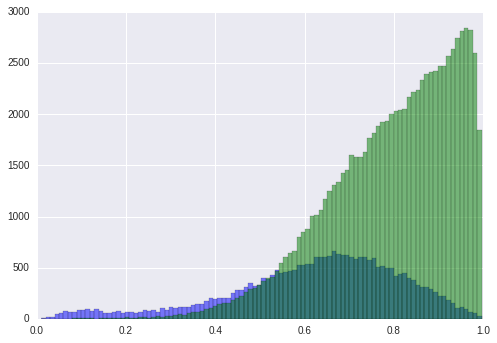

In [25]:
z = plt.hist(preds[target==0], bins=100, color='blue', alpha=.5)
y = plt.hist(preds[target==1], bins=z[1], color='green', alpha=.5)

In [26]:
from sklearn.metrics import log_loss, roc_auc_score

In [28]:
log_loss(target, preds)

0.45618604030010573

In [29]:
roc_auc_score(target, preds)

0.77146265292454141

In [32]:
def ll_tune(data, low, high, low_mul, high_mul):
    def make(x, low, high, low_mul, high_mul):
        if x < low: x = 0.
        elif x > high: x = 1.
        elif x < .5: x *= low_mul
        else: x *= high_mul
        return x
    return np.vectorize(make)(data, low, high, low_mul, high_mul)

a = np.array([.1, .4, .6, .9])
ll_tune(a, .2, .8, .5, .5)

array([ 0. ,  0.2,  0.3,  1. ])

In [ ]:
trainX, testX, trainY, testY = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=42)
clf.fit(trainX, trainY)
pred = clf.predict_proba(testX)

In [33]:
%%time
from copy import copy
res = list()
for low in np.linspace(0., .5, 100):
    for high in np.linspace(.5, 1., 100):
        for low_mul in np.linspace(1., 1.5, 1):
            for high_mul in np.linspace(1., 1., 1):
                res.append((log_loss(target, ll_tune(copy(preds), low, high, low_mul, high_mul)), (low, high, low_mul, high_mul)))

CPU times: user 6min 41s, sys: 2.79 s, total: 6min 43s
Wall time: 6min 43s


In [38]:
print (log_loss(target, preds), log_loss(target, ll_tune(copy(preds), 0, 1, 1, 1)))
for r in sorted(res, key=lambda x: x[0])[:20]:
    print (r) 

0.4561860403 0.4561860403
(0.45616690252986725, (0.045454545454545456, 1.0, 1.0, 1.0))
(0.45617454663977225, (0.040404040404040407, 1.0, 1.0, 1.0))
(0.45617929505132615, (0.035353535353535359, 1.0, 1.0, 1.0))
(0.45618187274056599, (0.030303030303030304, 1.0, 1.0, 1.0))
(0.45618308083737047, (0.025252525252525256, 1.0, 1.0, 1.0))
(0.45618490325739569, (0.020202020202020204, 1.0, 1.0, 1.0))
(0.45618570823205751, (0.015151515151515152, 1.0, 1.0, 1.0))
(0.45618604030010573, (0.0, 1.0, 1.0, 1.0))
(0.45618604030010573, (0.0050505050505050509, 1.0, 1.0, 1.0))
(0.45618604030010573, (0.010101010101010102, 1.0, 1.0, 1.0))
(0.45643025020948813, (0.050505050505050511, 1.0, 1.0, 1.0))
(0.45644880513164166, (0.045454545454545456, 1.0, 1.0555555555555556, 1.0))
(0.45645688388538425, (0.040404040404040407, 1.0, 1.0555555555555556, 1.0))
(0.4564619015829055, (0.035353535353535359, 1.0, 1.0555555555555556, 1.0))
(0.45646462498510937, (0.030303030303030304, 1.0, 1.0555555555555556, 1.0))
(0.4564659011893

In [30]:
preds.mean()

0.75614516185600322

In [31]:
target.mean()

0.76119872989214576

In [ ]:
#train.loc[:, 'user_type'] = (train.isnull().sum(axis=1) > 60)
#test.loc[:, 'user_type'] = (test.isnull().sum(axis=1) > 60)
print('Clearing...')
for (train_name, train_series), (test_name, test_series) in zip(train.iteritems(),test.iteritems()):
    if train_series.dtype == 'O':
        #for objects: factorize
        train[train_name], tmp_indexer = pd.factorize(train[train_name])
        test[test_name] = tmp_indexer.get_indexer(test[test_name])
        #but now we have -1 values (NaN)
    else:
        #for int or float: fill NaN
        tmp_len = len(train[train_series.isnull()])
        if tmp_len>0:
            #print "mean", train_series.mean()
            train.loc[train_series.isnull(), train_name] = -999
        #and Test
        tmp_len = len(test[test_series.isnull()])
        if tmp_len>0:
            test.loc[test_series.isnull(), test_name] = -999
           

X_train = train
X_test = test
print('Training...')
extc = ExtraTreesClassifier(n_estimators=2850,max_features= 60,criterion= 'entropy',min_samples_split= 4,
                            max_depth= 40, min_samples_leaf= 2, n_jobs = -1)      
 
extc.fit(X_train,target)
 
print('Predict...')
y_pred = extc.predict_proba(X_test)
#print y_pred
 
pd.DataFrame({"ID": id_test, "PredictedProb": y_pred[:,1]}).to_csv('extra_trees.csv',index=False)